# End-to-End Sample Processing Tutorial with SarcGraph and Z-Disc Classifier

In this tutorial, we’ll walk through how to use SarcGraph and our z-disc classifier to analyze hiPSC-CM images. The steps include contour detection using SarcGraph, classification with Dino+MLP or EfficientNet+SimCLR, sarcomere detection with SarcGraph, feature extraction.

## 1. Contour Detection with SarcGraph


In [1]:
# Import and initialize SarcGraph
from sarcgraph import SarcGraph

sg = SarcGraph(
    num_neighbors=5,
    angle_threshold=1.75,
    max_sarc_length=20.0,
    zdisc_min_length=15,
    zdisc_max_length=200,
    input_type="image",
    sigma=2.0
)

output_dir = output
input_type = image
save_output = True
sigma = 2.0
zdisc_min_length = 15
zdisc_max_length = 200
full_track_ratio = 0.75
tp_depth = 4
skip_merge = False
num_neighbors = 5
avg_sarc_length = 15.0
min_sarc_length = 0.0
max_sarc_length = 20.0
coeff_avg_length = 1.0
coeff_neighbor_length = 1.0
coeff_neighbor_angle = 1.0
score_threshold = 0.1
angle_threshold = 1.75


Loaded raw image shape: (632, 424)
Detected 195 contours and 195 z-disc points


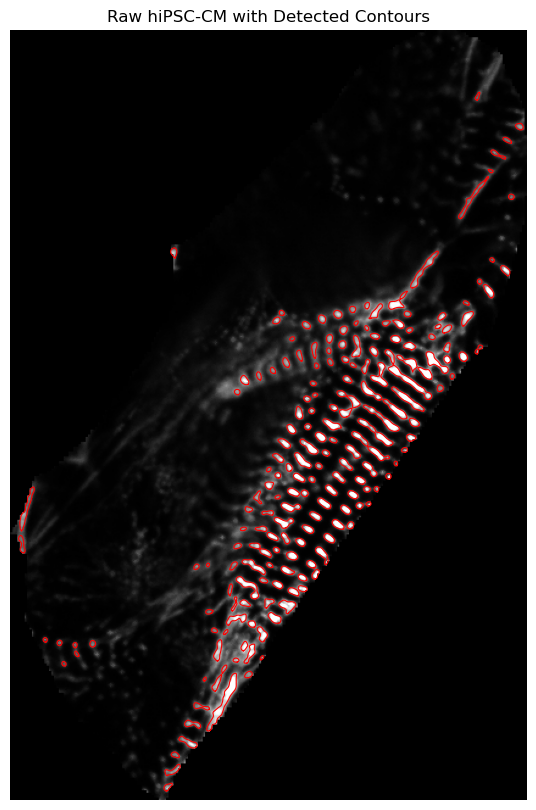

In [4]:
import numpy as np
import matplotlib.pyplot as plt


# Load a sample raw image
raw_image = np.load("sample_data/sample_raw.npy").astype(np.float32)

# Run z-disc segmentation step of SarcGraph
zdiscs = sg.zdisc_segmentation(raw_frames=raw_image)

# Load contours saved from preprocessing
contours = np.load('output/contours.npy', allow_pickle=True)[0]

print(f"Loaded raw image shape: {raw_image.shape}")
print(f"Detected {len(contours)} contours and {len(zdiscs)} z-disc points")

# Visualize the raw image with detected contours
plt.figure(figsize=(10, 10))
plt.imshow(raw_image, cmap='gray')
plt.axis('off')
for cnt in contours:
    plt.plot(cnt[:,1], cnt[:,0], color='red', linewidth=0.8)
plt.title('Raw hiPSC-CM with Detected Contours')
plt.show()

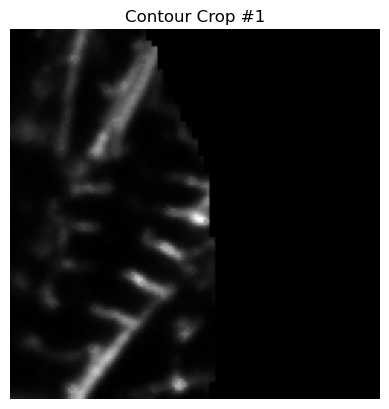

In [6]:
# Generate contour crops as inputs of our classifiers
import os

from sarcomere_detection.preprocessing_utils import generate_contour_images

cropped = generate_contour_images(
    zdiscs,
    raw_image,
    contours,
    crop_size=128
)

# Visualize one sample crop
idx = 1
plt.imshow(cropped[idx][:, :, 2], cmap='gray')
plt.title(f'Contour Crop #{idx}')
plt.axis('off')
plt.show()

# Save the crops for later use
os.makedirs('sample_output', exist_ok=True)
np.save('sample_output/cropped_contours.npy', cropped)

## 2. Z-Disc Classification with DINOv2 and Our Pretrained MLP

In order to use our pretrained MLP models, you need to download the weights from the [Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/3AIJKU). 

Instructions for downloading the models with python can be found in the `dowload-data-tutorial.ipynb` notebook.

**Note:** To run the following code, we recommend using a GPU-enabled environment with PyTorch installed. If you don't have a GPU, you can still run the code, but it will be significantly slower.

Inference complete!


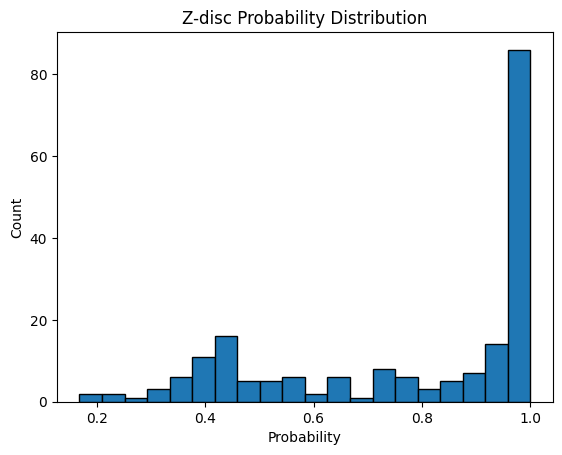

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import clear_output

from classification.dino.mlp_classifier import infer_zdisc_logits

# Load the cropped contours
cropped = np.load('sample_output/cropped_contours.npy')

# Run inference and obtain logits
num_models = 5  # Select the number of models to use for inference
logits = []
for i in range(num_models):
    clear_output(wait=True) # Clear previous output before printing the new status
    print(f"Inference using model {i+1}/{num_models}...")

    model_path = f'./dino_mlp_models/model_{i}.pt'
    logits.append(
        infer_zdisc_logits(
            cropped,
            model_path,
            batch_size=16
        )
    )

# Average logits across models
logits = np.mean(logits, axis=0)

# Convert logits to probabilities for the Z-disc class (index=1)
temperature = 2.0  # Adjust temperature if needed
logits /= temperature
probs = F.softmax(torch.from_numpy(logits), dim=1)[:, 1].cpu().numpy()

np.save('sample_output/zdisc_probs.npy', probs)

clear_output(wait=True)
print("Inference complete!")

# Plot probability histogram
plt.hist(probs, bins=20, edgecolor='black')
plt.title('Z-disc Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()

## 3. Sarcomere Detection and Feature Extraction with SarcGraph

After obtaining the z-disc probabilities, we can use SarcGraph to detect sarcomeres and extract cell structural features.

In [1]:
import numpy as np

from sarcomere_detection.main_pipeline import process_single_sample

from sarcgraph import SarcGraph

# Initialize SarcGraph with desired configs
sg = SarcGraph(
    num_neighbors=5,
    angle_threshold=1.75,
    min_sarc_length = 10.0,
    avg_sarc_length=14.0,
    max_sarc_length=18.0,
    zdisc_min_length=15,
    zdisc_max_length=200,
    input_type="image",
    sigma=2.0,
)

# Load necessary data
raw_image = np.load("sample_data/sample_raw.npy").astype(np.float32)
cell_mask = np.load("sample_data/sample_mask.npy")
probabilities = np.load("sample_output/zdisc_probs.npy")

# Process the sample using SarcGraph
sample_id = 0
PIXEL_TO_MICRON = 207.5 / 1736
features, sarcomeres_graph = process_single_sample(sample_id, raw_image, cell_mask, probabilities, sg, PIXEL_TO_MICRON)

output_dir = output
input_type = image
save_output = True
sigma = 2.0
zdisc_min_length = 15
zdisc_max_length = 200
full_track_ratio = 0.75
tp_depth = 4
skip_merge = False
num_neighbors = 5
avg_sarc_length = 14.0
min_sarc_length = 10.0
max_sarc_length = 18.0
coeff_avg_length = 1.0
coeff_neighbor_length = 1.0
coeff_neighbor_angle = 1.0
score_threshold = 0.1
angle_threshold = 1.75


/home/ghost/sarcgraph/sarcgraph/sg.py:943: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(np.dot(v1, v2) / (l1 * l2)) / (np.pi / 2)


In [2]:
features

,sample_id,sarcomeres_mean_length,sarcomeres_std_length,sarcomeres_count,myofibrils_count,sarcomeres_per_myofibril,oop,cell_area,z_disc_probability_weighted_area,z_disc_ratio
0,0,1.623188,0.206804,100,20,5.0,0.745073,1878.207639,86.663315,0.764103


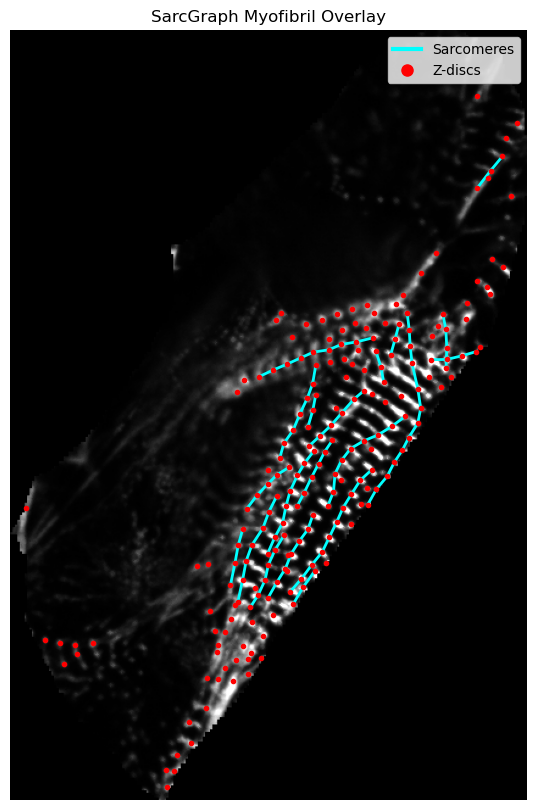

In [7]:
import matplotlib.pyplot as plt

# Display the raw image as background
plt.figure(figsize=(10, 10))
plt.imshow(raw_image, cmap='gray')
plt.axis('off')

# Plot sarcomeres: draw lines between connected z-discs without labeling each
for u, v in sarcomeres_graph.edges():
    x1, y1 = sarcomeres_graph.nodes[u]['pos']
    x2, y2 = sarcomeres_graph.nodes[v]['pos']
    plt.plot([y1, y2], [x1, x2], color='cyan', linewidth=2)

# Highlight z-disc nodes as red bullets
for node, data in sarcomeres_graph.nodes(data=True):
    x, y = data['pos']
    plt.plot(y, x, '.', color='red', ms=6)

# Create custom legend handles
import matplotlib.lines as mlines
sar_line = mlines.Line2D([], [], color='cyan', linewidth=3, label='Sarcomeres')
disc_dot = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=8, label='Z-discs')
plt.legend(handles=[sar_line, disc_dot])

plt.title('SarcGraph Myofibril Overlay')
plt.show()